# Predicting SBA Guaranteed Loans Defaults

# Readme

Our Target Variable will be 'MIS_Status'

Ho : There are no statistically significant predictors for whether an SBA guaranteed loan will default.

Ha : There exist statistically significant predictors for whether an SBA guaranteed loan will default.

The Data below presents with a target label 'MIS_Status' meant to classify whether an SBA guaranteed loan is paid in full at maturity or if the loan has to be charged off, thereby leaving the SBA to pick up the bill for the remaining of the loan balance, and even more so, leaving the original bank to eat the losses incurred by the difference in what the SBA guaranteed and the balance still left on the account.

Therefore the task we have before us, is primarily one of Classification(but regression models can also be applied). We will attempt to use the provided dataset and apply a machine learning algorithm, so that we might predict a discrete label output for future SBA guaranteed loans.

Can we predict, based on observed character traits of past accounts, with statistically significant probability that an account will default on its SBA guaranteed loan?

In [1]:
import pandas as pd

In [2]:
var_descr = pd.read_excel(r'C:\Users\ASUS\Thinkful_Projects\Capstone_2_Notes\Variable_Descriptions.xlsx')
var_descr

,Variable Name,Data Type,Description of variable
0,LoanNr_ChkDgt,Text,Identifier – Primary Key
1,Name,Text,Borrower Name
2,City,Text,Borrower City
3,State,Text,Borrower State
4,Zip,Text,Borrower Zip Code
5,Bank,Text,Bank Name
6,BankState,Text,Bank State
7,NAICS,Text,North American Industry Classification System ...
8,ApprovalDate,Date/Time,Date SBA Commitment Issued
9,ApprovalFY,Text,Fiscal Year of Commitment


# Import Relevant Libraries

In [3]:
# Basic Libraries:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#import pandas_profiling as pp
import datetime
import math
from datetime import date
from scipy import stats
import gc
import time

#Feature Selection:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

#Balancing the Dataset:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

#Model Evaluation:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, f1_score,auc,roc_curve,roc_auc_score, log_loss, make_scorer, precision_recall_curve
import scikitplot as skplt

#Modeling Algoritms:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

Data sourced from: https://www.tandfonline.com/doi/full/10.1080/10691898.2018.1434342?scroll=top&needAccess=true

## Read in the dataset:

In [4]:
loans = pd.read_csv(r'C:\Users\ASUS\Thinkful_Projects\Capstone_2_notes\archive (6)\SBANational.csv')
loans.head(3)

C:\Users\ASUS\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"


Reading in the dataset, revealed several discrepancies that needed to be addressed. Luckily, some of them could be addressed, immediately upon reading in the file. While others had to be cleaned below.

In [5]:
date_columns = ['ApprovalDate', 'DisbursementDate']
dtypes = {'ApprovalDate': 'str', 'DisbursementDate': 'str', 'ApprovalFY': 'str'}
df = pd.read_csv(
    r'C:\Users\ASUS\Thinkful_Projects\Capstone_2_notes\archive (6)\SBANational.csv',
    dtype=dtypes, parse_dates=date_columns).drop(columns=['Name', 'BankState']
                                                )
#del loans
#gc.collect()

df

,LoanNr_ChkDgt,City,State,Zip,Bank,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,EVANSVILLE,IN,47711,FIFTH THIRD BANK,451120,1997-02-28,1997,84,4,...,N,Y,NaN,1999-02-28,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,NEW PARIS,IN,46526,1ST SOURCE BANK,722410,1997-02-28,1997,60,2,...,N,Y,NaN,1997-05-31,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,621210,1997-02-28,1997,180,7,...,N,N,NaN,1997-12-31,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,0,1997-02-28,1997,60,2,...,N,Y,NaN,1997-06-30,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,0,1997-02-28,1997,240,14,...,N,N,NaN,1997-05-14,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899159,9995573004,UPPER ARLINGTON,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,451120,1997-02-27,1997,60,6,...,0,N,NaN,1997-09-30,"$70,000.00",$0.00,P I F,$0.00,"$70,000.00","$56,000.00"
899160,9995603000,COLUMBUS,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,451130,1997-02-27,1997,60,6,...,Y,N,NaN,1997-10-31,"$85,000.00",$0.00,P I F,$0.00,"$85,000.00","$42,500.00"
899161,9995613003,SANTA MARIA,CA,93455,"RABOBANK, NATIONAL ASSOCIATION",332321,1997-02-27,1997,108,26,...,N,N,NaN,1997-09-30,"$300,000.00",$0.00,P I F,$0.00,"$300,000.00","$225,000.00"
899162,9995973006,HONOLULU,HI,96830,BANK OF HAWAII,0,1997-02-27,1997,60,6,...,N,Y,8-Mar-00,1997-03-31,"$75,000.00",$0.00,CHGOFF,"$46,383.00","$75,000.00","$60,000.00"


In [6]:
# Something is off with the Approval Date.
df.ApprovalDate.max()

Timestamp('2069-10-13 00:00:00')

In [7]:
df.loc[(df.DisbursementDate >= '2000-01-1')].describe()

,LoanNr_ChkDgt,Zip,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural
count,5.704530e+05,570453.000000,570453.000000,570453.000000,570453.000000,570317.000000,570453.000000,570453.000000,570453.000000,570453.000000
mean,4.464962e+09,52449.166564,502341.360747,95.563151,8.819282,1.284782,2.466519,5.956335,2690.727634,1.158700
std,2.330456e+09,31507.789375,191410.050435,70.020043,47.486081,0.453381,21.498781,29.124984,12676.381975,0.419256
min,1.000146e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.496706e+09,22204.000000,423440.000000,60.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,3.986455e+09,53818.000000,512191.000000,84.000000,4.000000,1.000000,0.000000,2.000000,1.000000,1.000000
75%,6.319224e+09,83702.000000,621391.000000,96.000000,8.000000,2.000000,2.000000,6.000000,1.000000,1.000000
max,9.995393e+09,99999.000000,928120.000000,569.000000,9999.000000,2.000000,8800.000000,9500.000000,92006.000000,2.000000


## Dial in on Time Period

The current dataset only carries observations of SBA Guarantees that were committed through the 2014 Fiscal Year. As we can see from the descriptive statistics above, regarding "Term" - only 25% of the loan terms are 5 years or less. Analyzing "DisbursementDate" > 2010 will unequally affect our target variable outcomes. 

A loan can only be charged-off BEFORE maturity, while a loan only becomes "Paid-In-Full" at maturity. "Since this dataset has been restricted to loans for which the outcome is known, there is a greater chance that those loans charged off prior to maturity date will be included in the dataset, while those that might be paid in full have been excluded."

In [8]:
time_period = df.copy()
#del df
#gc.collect()
time_period = time_period.loc[time_period['DisbursementDate'].between('2007-01-01', '2010-12-31')]
time_period

,LoanNr_ChkDgt,City,State,Zip,Bank,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
402,1003076008,CLEVELAND,MO,64734,COMMERCE BANK,238990,2006-02-07,2006,73,6,...,T,N,NaN,2008-06-30,"$40,254.00",$0.00,P I F,$0.00,"$25,000.00","$12,500.00"
420,1003206010,NORCROSS,GA,30093,FLORIDA BUS. DEVEL CORP,811192,2006-02-07,2006,240,1,...,0,N,NaN,2007-11-14,"$1,197,000.00",$0.00,P I F,$0.00,"$1,197,000.00","$1,197,000.00"
463,1003546007,ATLANTA,GA,30354,FLORIDA BUS. DEVEL CORP,812210,2006-02-07,2006,240,6,...,0,N,NaN,2007-03-14,"$263,000.00",$0.00,P I F,$0.00,"$263,000.00","$263,000.00"
470,1003616004,LINDON,UT,84042,MOUNTAIN W. SMALL BUS. FINAN,441229,2006-02-07,2006,240,3,...,0,N,NaN,2009-12-16,"$264,000.00",$0.00,P I F,$0.00,"$264,000.00","$264,000.00"
620,1004566004,ABILENE,TX,79605,CAPITAL CERT. DEVEL CORP,721110,2006-02-07,2006,240,15,...,0,N,NaN,2007-08-15,"$1,352,000.00",$0.00,P I F,$0.00,"$1,352,000.00","$1,352,000.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893442,9873094000,IDAHO FALLS,ID,83401,EAST-CENTRAL IDAHO DEVEL CO,441310,2006-02-03,2006,240,2,...,0,N,NaN,2008-01-16,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"
894473,9892164003,OVERLAND PARK,KS,66213,COMMERCE BANK,722320,2006-02-06,2006,60,2,...,0,N,NaN,2009-01-31,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$20,000.00"
894536,9893464001,HARTSVILLE,TN,37074,MID-CUMBERLAND AREA DEVEL CORP,722110,2006-02-06,2006,240,10,...,0,N,NaN,2007-07-11,"$150,000.00",$0.00,P I F,$0.00,"$150,000.00","$150,000.00"
894766,9897464009,ROCKLIN,CA,95765,CDC SMALL BUS. FINAN CORP,332611,2006-02-06,2006,240,5,...,0,N,NaN,2007-07-11,"$134,000.00",$0.00,P I F,$0.00,"$134,000.00","$134,000.00"


## First look at the data

In [9]:
print("-----------Information-----------")
print(time_period.info())
print("----------Missing values-----------")
print(time_period.isnull().sum().sort_values(ascending=False))
print("----------Null values-----------")
print(time_period.isna().sum().sort_values(ascending=False))
print("----------Value Counts of Each Column in Data----------")
print(time_period.nunique().sort_values(ascending=False))
print("----------Duplicates in Data----------")
print('Number of duplicates:', len(time_period[time_period.duplicated()]))

-----------Information-----------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 144748 entries, 402 to 894809
Data columns (total 25 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   LoanNr_ChkDgt      144748 non-null  int64         
 1   City               144748 non-null  object        
 2   State              144748 non-null  object        
 3   Zip                144748 non-null  int64         
 4   Bank               144747 non-null  object        
 5   NAICS              144748 non-null  int64         
 6   ApprovalDate       144748 non-null  datetime64[ns]
 7   ApprovalFY         144748 non-null  object        
 8   Term               144748 non-null  int64         
 9   NoEmp              144748 non-null  int64         
 10  NewExist           144643 non-null  float64       
 11  CreateJob          144748 non-null  int64         
 12  RetainedJob        144748 non-null  int64         
 13  Franchis

Note: Even though our DataFrame Duplicates are reading as zero, that is solely based on the most varied column, 'LoanNr_ChkDgt', meaning that multiple businesses have applied and received SBA Guaranteed loans during the period in question.

The 'ApprovalFY' column appears to be stubbornly holding onto an 'object' dtype because of value '1976A'.

In [10]:
#df_copy.ApprovalFY.value_counts().sort_values(ascending=True)
time_period.ApprovalFY.replace('1976A', '1976', inplace =True)
#df_copy.ApprovalFY.value_counts().sort_values(ascending=True)
time_period.ApprovalFY = time_period.ApprovalFY.astype('int')
time_period.ApprovalFY.dtypes

dtype('int32')

## Convert Currency Columns

In [11]:
dollar_cols = ['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']
df_2 = time_period.copy()

#del time_period
#gc.collect()

df_2[dollar_cols] = df_2[dollar_cols].replace('[\$,]', '', regex=True).astype(float)

In [12]:
# Percentage of charged off balances, with regard to total disbursed amounts, since 2007
df_2.ChgOffPrinGr.sum()/df_2.DisbursementGross.sum()

0.1301038276877628

In [13]:
#df_2.groupby(['ApprovalFY']).mean()

,LoanNr_ChkDgt,Zip,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,DisbursementGross,BalanceGross,ChgOffPrinGr,GrAppv,SBA_Appv
ApprovalFY,,,,,,,,,,,,,,,
1986,2.692933e+09,60601.500000,0.000000,32.500000,6.500000,1.500000,4400.000000,4400.000000,0.000000,0.000000,221000.000000,0.000000,42117.500000,221000.000000,190650.000000
1996,9.108443e+09,8078.000000,561740.000000,181.000000,6.000000,1.000000,0.000000,0.000000,1.000000,0.000000,72000.000000,0.000000,0.000000,72000.000000,36000.000000
2000,3.565224e+09,32732.000000,270609.500000,102.000000,4.000000,1.500000,0.000000,0.000000,1.000000,1.500000,71000.000000,0.000000,0.000000,71000.000000,53800.000000
2001,4.529648e+09,24297.428571,470015.714286,72.285714,10.000000,1.142857,1.571429,9.857143,1.000000,1.000000,58847.142857,0.000000,3370.571429,57857.142857,30928.571429
2002,5.554966e+09,12248.406667,520926.153333,80.826667,5.373333,1.013333,1.073333,5.586667,1.000000,1.006667,29831.293333,0.000000,144.433333,28994.000000,18637.000000
2003,6.144685e+09,20297.785294,536960.726471,87.035294,6.697059,1.091176,2.047059,5.108824,1330.700000,1.135294,79470.820588,0.000000,2113.667647,78985.035294,66517.432353
2004,6.269046e+09,38509.943894,523343.797030,94.754125,5.141914,1.219472,2.127063,3.216172,1273.590759,1.145215,110540.531353,0.000000,1989.069307,108117.968647,91647.759076
2005,4.962669e+09,38406.158838,531363.211372,108.239802,7.523486,1.359085,4.069839,4.555624,2111.003708,1.178616,228455.720025,0.000000,5522.606922,226113.373918,207035.404203
2006,2.570633e+09,49832.368006,523122.781091,117.250658,8.936152,1.353447,4.177688,4.975794,2805.971409,1.221189,247576.721803,0.000000,11804.101386,241528.625855,219903.261182


MIS_Status will be our target variable, and yet, we are presented with 284 null values for the field. Let's examine if there might be some way to fill in any of those null values via other corresponding columns.

In [14]:
df_2.MIS_Status.isnull().sum()

434

I searched for observations that had an MIS_Status of Null and either a Charge Off Date or Charge Off Amount. It turns out that where there are 41 observations out of 434 that seemingly should not be null.

In [15]:
df_2.loc[
    (df_2.MIS_Status.isnull()) & 
    (df_2.ChgOffDate.notnull() | (df_2.ChgOffPrinGr != 0.0))
]

,LoanNr_ChkDgt,City,State,Zip,Bank,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
20880,1154585009,QUEENSBURY,NY,12804,CITIZENS BANK NATL ASSOC,811122,2005-01-11,2005,26,1,...,N,N,7-Feb-11,2008-12-31,2697.0,0.0,NaN,4891.0,5000.0,2500.0
31469,1237295000,WESTBOROUGH,MA,1581,CITIZENS BANK NATL ASSOC,236118,2005-03-18,2005,12,1,...,N,N,30-Sep-11,2008-11-30,3972.0,0.0,NaN,471.0,5000.0,2500.0
49697,1384135009,BURLINGTON,VT,5401,CITIZENS BANK NATL ASSOC,448140,2005-07-22,2005,59,4,...,N,N,19-Apr-10,2007-02-28,330.0,0.0,NaN,1771.0,5000.0,2500.0
62250,1469845009,WOODLYN,PA,19094,CITIZENS BANK NATL ASSOC,453220,2005-09-23,2005,67,1,...,N,N,31-Jan-09,2007-07-31,663.0,0.0,NaN,1802.0,10000.0,5000.0
63833,1482365001,BUFFALO,NY,14225,CITIZENS BANK NATL ASSOC,524210,2005-09-30,2005,50,1,...,N,N,5-Jun-10,2007-03-31,706.0,0.0,NaN,662.0,2100.0,1050.0
64487,1487415002,BRANFORD,CT,6405,CITIZENS BANK NATL ASSOC,442110,2005-10-05,2006,37,2,...,N,N,29-Jul-11,2007-07-31,2868.0,0.0,NaN,4821.0,5000.0,2500.0
74361,1558315005,CANTON,OH,44708,CITIZENS BANK NATL ASSOC,484121,2005-11-30,2006,80,1,...,Y,N,29-Jun-10,2008-03-31,2500.0,0.0,NaN,2500.0,2500.0,1250.0
114124,1834655010,CICERO,NY,13039,CITIZENS BANK NATL ASSOC,812199,2006-05-23,2006,46,5,...,N,N,27-May-10,2007-04-30,987.0,0.0,NaN,931.0,1000.0,500.0
134304,1980335006,JAMESTOWN,NY,14701,CITIZENS BANK NATL ASSOC,811121,2006-08-21,2006,69,3,...,Y,N,29-Apr-09,2007-11-30,1934.0,0.0,NaN,1500.0,1500.0,750.0
175315,2251955009,STRONGSVILLE,OH,44136,CITIZENS BANK NATL ASSOC,451110,2007-02-01,2007,75,2,...,Y,N,14-Mar-08,2007-04-30,3671.0,0.0,NaN,1665.0,2000.0,1000.0


In [16]:
df_2.MIS_Status = np.where(df_2.MIS_Status.isnull() & df_2.ChgOffDate.notnull(), 'CHGOFF', df_2.MIS_Status)

In [17]:
df_2.loc[
    (df_2.MIS_Status.isnull()) & 
    (df_2.ChgOffDate.notnull() | (df_2.ChgOffPrinGr != 0.0))
]

,LoanNr_ChkDgt,City,State,Zip,Bank,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv


## Drop

In [18]:
# Certain columns while initially helpful, have outlived their usefulness, as they won't help our model(s) 
# predict whether a loan will default or not. 

# I have plans for the Disbursment Date, so we'll keep that one for now.
df_3 = df_2.drop(columns=['ChgOffDate', 'LoanNr_ChkDgt', 'BalanceGross', 'ChgOffPrinGr'])
#del df_2
#gc.collect()
df_4 = df_3.dropna(axis=0)
#del df_3
#gc.collect()

## Reassess Potential Features

In [19]:
print(df_4.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142188 entries, 402 to 894809
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   City               142188 non-null  object        
 1   State              142188 non-null  object        
 2   Zip                142188 non-null  int64         
 3   Bank               142188 non-null  object        
 4   NAICS              142188 non-null  int64         
 5   ApprovalDate       142188 non-null  datetime64[ns]
 6   ApprovalFY         142188 non-null  int32         
 7   Term               142188 non-null  int64         
 8   NoEmp              142188 non-null  int64         
 9   NewExist           142188 non-null  float64       
 10  CreateJob          142188 non-null  int64         
 11  RetainedJob        142188 non-null  int64         
 12  FranchiseCode      142188 non-null  int64         
 13  UrbanRural         142188 non-null  int64 

In [20]:
df_4.UrbanRural.value_counts()
# Leave as-is

1    114510
2     26941
0       737
Name: UrbanRural, dtype: int64

In [21]:
df_4.NewExist.value_counts()
# We'll go ahead and drop the 0 values, as the documentation, doesn't specify a categorical importance to that value.

1.0    96504
2.0    45675
0.0        9
Name: NewExist, dtype: int64

In [22]:
df_5 = df_4.copy()
#del df_4
#gc.collect()
df_5 = df_5.loc[(df_5.NewExist != 0.0)]
df_5.NewExist.value_counts()

1.0    96504
2.0    45675
Name: NewExist, dtype: int64

In [23]:
df_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142179 entries, 402 to 894809
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   City               142179 non-null  object        
 1   State              142179 non-null  object        
 2   Zip                142179 non-null  int64         
 3   Bank               142179 non-null  object        
 4   NAICS              142179 non-null  int64         
 5   ApprovalDate       142179 non-null  datetime64[ns]
 6   ApprovalFY         142179 non-null  int32         
 7   Term               142179 non-null  int64         
 8   NoEmp              142179 non-null  int64         
 9   NewExist           142179 non-null  float64       
 10  CreateJob          142179 non-null  int64         
 11  RetainedJob        142179 non-null  int64         
 12  FranchiseCode      142179 non-null  int64         
 13  UrbanRural         142179 non-null  int64 

In [24]:
df_5['Is_New'] = np.where(df_5['NewExist'] == 2.0, 1, 0)

In [25]:
# Revolving Line of Credit should be: Y = Yes and N = No. There too much unknown variabilty here for us
# to keep this column. And removing the rows that are not Y or N, would wipe out a good chunk of our data.
print(df_5.RevLineCr.value_counts())
df_6 = df_5.drop(columns=['RevLineCr', 'NewExist'])
#del df_5
#gc.collect()

N    58717
Y    57854
0    22658
T     2947
1        3
Name: RevLineCr, dtype: int64


In [26]:
# Revolving Low Doc should be also be: Y = Yes and N = No. The extra keys, represent a small enough portion of the data,
# that I feel comfortable removing the rows from further use.
print(df_6.LowDoc.value_counts())
df_7 = df_6.copy()
#del df_6
#gc.collect()
df_7 = df_7.loc[(df_7.LowDoc == 'N') | (df_7.LowDoc == 'Y')]

N    141035
S       528
A       475
R        64
Y        41
C        36
Name: LowDoc, dtype: int64


In [27]:
df_7.LowDoc.value_counts()

N    141035
Y        41
Name: LowDoc, dtype: int64

In [28]:
df_7['LowDoc'] = np.where(df_7['LowDoc'] == 'Y', 1, 0)

The SBA in its Data Dictionary('http://imedia.sba.gov/vd/general/foia/7a_504_FOIA%20Data%20Dictionary.xlsx') states, "Total Jobs Created + Jobs Retained as reported by lender on SBA Loan Application.  SBA does not review, audit, or validate these numbers - they are simply self-reported, good faith estimates by the lender."

'RetainedJob', 'CreateJob', and 'FranchiseCode' all have prominent values for 0, further analysis would benefit from establishing a binary response from these categorical columns. Did the loan help retain jobs, create jobs, and was the business among the SBA's Franchise Directory? Rather than a count of all the values within those categories.

In [29]:
df_7.RetainedJob.value_counts()

1      26051
2      22140
0      18667
3      13870
4      10781
       ...  
232        1
213        1
967        1
430        1
188        1
Name: RetainedJob, Length: 211, dtype: int64

In [30]:
df_7.CreateJob.value_counts()

0       74918
1       18199
2       15801
3        7340
4        4970
        ...  
76          1
81          1
210         1
1618        1
180         1
Name: CreateJob, Length: 153, dtype: int64

In [31]:
df_7.FranchiseCode.value_counts()

0        101208
1         34039
78760       348
68020       141
16920       106
          ...  
20944         1
35619         1
38560         1
81790         1
84059         1
Name: FranchiseCode, Length: 1046, dtype: int64

In [32]:
df_7['FranchiseCode'] = np.where(df_7['FranchiseCode'] > 1, 1, 0)
df_7['CreateJob'] = np.where(df_7['CreateJob'] > 1, 1, 0)
df_7['RetainedJob'] = np.where(df_7['RetainedJob'] > 1, 1, 0)

In [33]:
# Term can be simplified to a yearly basis vs. its current monthly tally.
df_7.Term = df_7.Term//12

In [34]:
df_7

,City,State,Zip,Bank,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,CreateJob,RetainedJob,FranchiseCode,UrbanRural,LowDoc,DisbursementDate,DisbursementGross,MIS_Status,GrAppv,SBA_Appv,Is_New
402,CLEVELAND,MO,64734,COMMERCE BANK,238990,2006-02-07,2006,6,6,0,1,0,1,0,2008-06-30,40254.0,P I F,25000.0,12500.0,0
420,NORCROSS,GA,30093,FLORIDA BUS. DEVEL CORP,811192,2006-02-07,2006,20,1,1,0,0,1,0,2007-11-14,1197000.0,P I F,1197000.0,1197000.0,0
463,ATLANTA,GA,30354,FLORIDA BUS. DEVEL CORP,812210,2006-02-07,2006,20,6,1,1,0,1,0,2007-03-14,263000.0,P I F,263000.0,263000.0,0
470,LINDON,UT,84042,MOUNTAIN W. SMALL BUS. FINAN,441229,2006-02-07,2006,20,3,1,1,0,2,0,2009-12-16,264000.0,P I F,264000.0,264000.0,0
620,ABILENE,TX,79605,CAPITAL CERT. DEVEL CORP,721110,2006-02-07,2006,20,15,1,1,1,1,0,2007-08-15,1352000.0,P I F,1352000.0,1352000.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893442,IDAHO FALLS,ID,83401,EAST-CENTRAL IDAHO DEVEL CO,441310,2006-02-03,2006,20,2,1,0,0,1,0,2008-01-16,229000.0,P I F,229000.0,229000.0,0
894473,OVERLAND PARK,KS,66213,COMMERCE BANK,722320,2006-02-06,2006,5,2,1,1,0,1,0,2009-01-31,40000.0,P I F,40000.0,20000.0,0
894536,HARTSVILLE,TN,37074,MID-CUMBERLAND AREA DEVEL CORP,722110,2006-02-06,2006,20,10,1,0,0,2,0,2007-07-11,150000.0,P I F,150000.0,150000.0,1
894766,ROCKLIN,CA,95765,CDC SMALL BUS. FINAN CORP,332611,2006-02-06,2006,20,5,1,0,0,2,0,2007-07-11,134000.0,P I F,134000.0,134000.0,0


In [35]:
df_7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141076 entries, 402 to 894809
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   City               141076 non-null  object        
 1   State              141076 non-null  object        
 2   Zip                141076 non-null  int64         
 3   Bank               141076 non-null  object        
 4   NAICS              141076 non-null  int64         
 5   ApprovalDate       141076 non-null  datetime64[ns]
 6   ApprovalFY         141076 non-null  int32         
 7   Term               141076 non-null  int64         
 8   NoEmp              141076 non-null  int64         
 9   CreateJob          141076 non-null  int32         
 10  RetainedJob        141076 non-null  int32         
 11  FranchiseCode      141076 non-null  int32         
 12  UrbanRural         141076 non-null  int64         
 13  LowDoc             141076 non-null  int32 

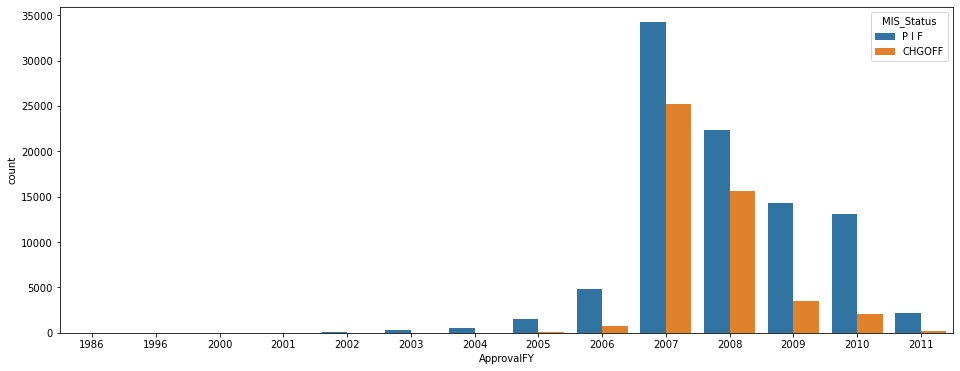

In [36]:
plt.figure(figsize=(16, 6))
sns.countplot(x='ApprovalFY', hue='MIS_Status', data=df_7); 

## Dependent Variable

In [37]:
df_7['Default'] = np.where(df_7['MIS_Status'] == 'P I F', 0, 1)

## Feature Engineering

In [38]:
# SBA loan terms of 20 years and greater have to be backed by real-estate collateral.
df_8 = df_7.copy().drop(columns=['MIS_Status'])
#del df_7
#gc.collect()
df_8['Real_Collateral'] = np.where(df_8['Term'] >= 20, 1, 0)

In [39]:
# Proportion of GrossApproved Amount vs. SBA Approved Amount.
df_8['SBA_Appv/GrAppv'] = df_8['SBA_Appv'] / df_8['GrAppv']

In [40]:
df_8['Industry'] = df_8['NAICS'].astype('str').apply(lambda x: x[:2])

In [41]:
df_8['Industry'] = df_8['Industry'].map({
    '11': 'Ag/For/Fish/Hunt',
    '21': 'Min/Quar/Oil_Gas_ext',
    '22': 'Utilities',
    '23': 'Construction',
    '31': 'Manufacturing',
    '32': 'Manufacturing',
    '33': 'Manufacturing',
    '42': 'Wholesale_trade',
    '44': 'Retail_trade',
    '45': 'Retail_trade',
    '48': 'Trans/Ware',
    '49': 'Trans/Ware',
    '51': 'Information',
    '52': 'Finance/Insurance',
    '53': 'RE/Rental/Lease',
    '54': 'Prof/Science/Tech',
    '55': 'Mgmt_comp',
    '56': 'Admin_sup/Waste_Mgmt_Rem',
    '61': 'Educational',
    '62': 'Healthcare/Social_assist',
    '71': 'Arts/Entertain/Rec',
    '72': 'Accom/Food_serv',
    '81': 'Other_no_pub',
    '92': 'Public_Admin'
})

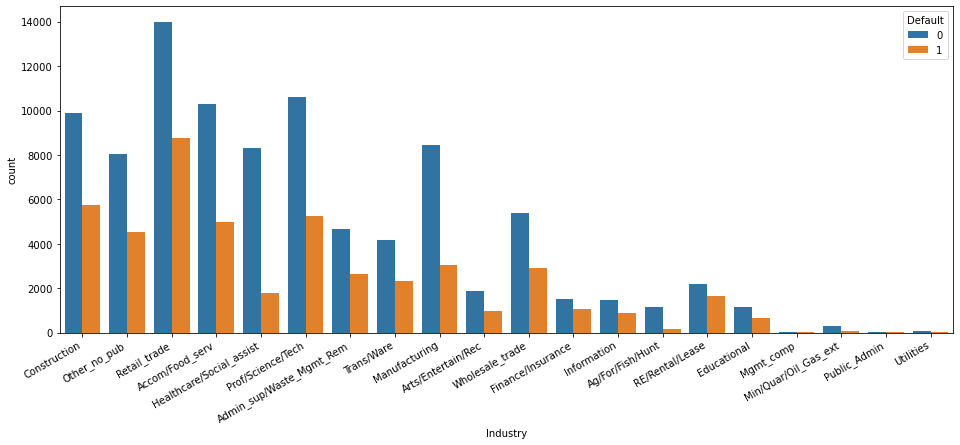

In [42]:
plt.figure(figsize=(16, 6))
ax=sns.countplot(x='Industry', hue='Default', data=df_8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize=10); 

In [43]:
df_9 = df_8.drop(columns=['City', 'Zip', 'Bank', 'ApprovalDate', 'DisbursementDate'])

In [44]:
df_9.dtypes

State                 object
NAICS                  int64
ApprovalFY             int32
Term                   int64
NoEmp                  int64
CreateJob              int32
RetainedJob            int32
FranchiseCode          int32
UrbanRural             int64
LowDoc                 int32
DisbursementGross    float64
GrAppv               float64
SBA_Appv             float64
Is_New                 int32
Default                int32
Real_Collateral        int32
SBA_Appv/GrAppv      float64
Industry              object
dtype: object

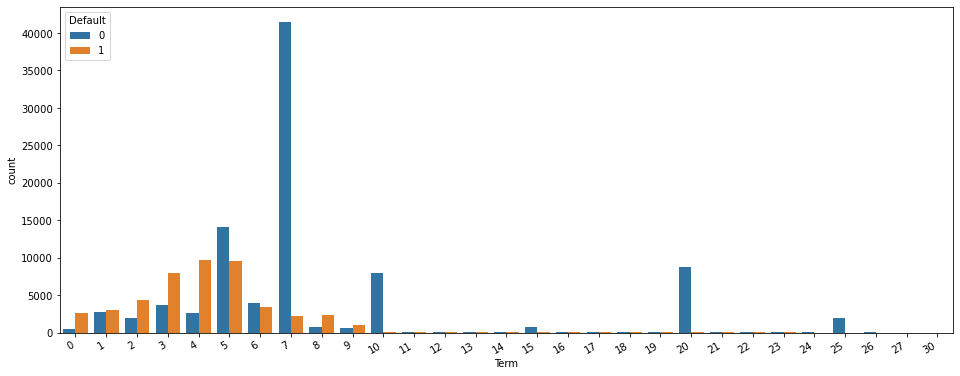

In [45]:
plt.figure(figsize=(16, 6))
ax=sns.countplot(x='Term', hue='Default', data=df_9)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize=10); 

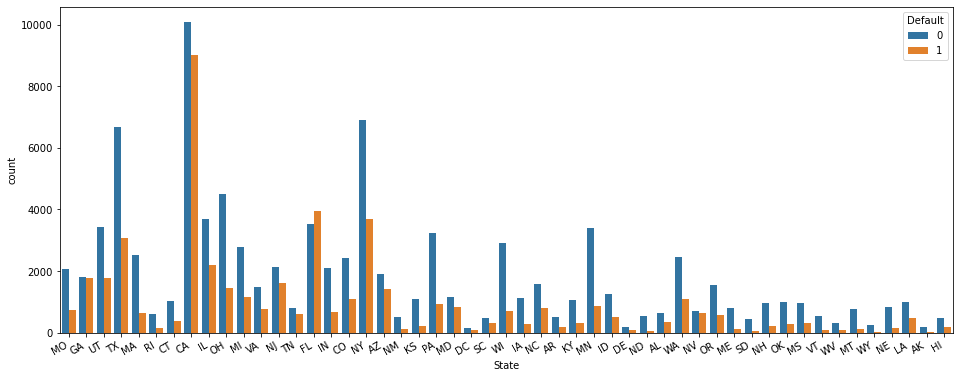

In [46]:
plt.figure(figsize=(16, 6))
ax=sns.countplot(x='State', hue='Default', data=df_9)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize=10); 

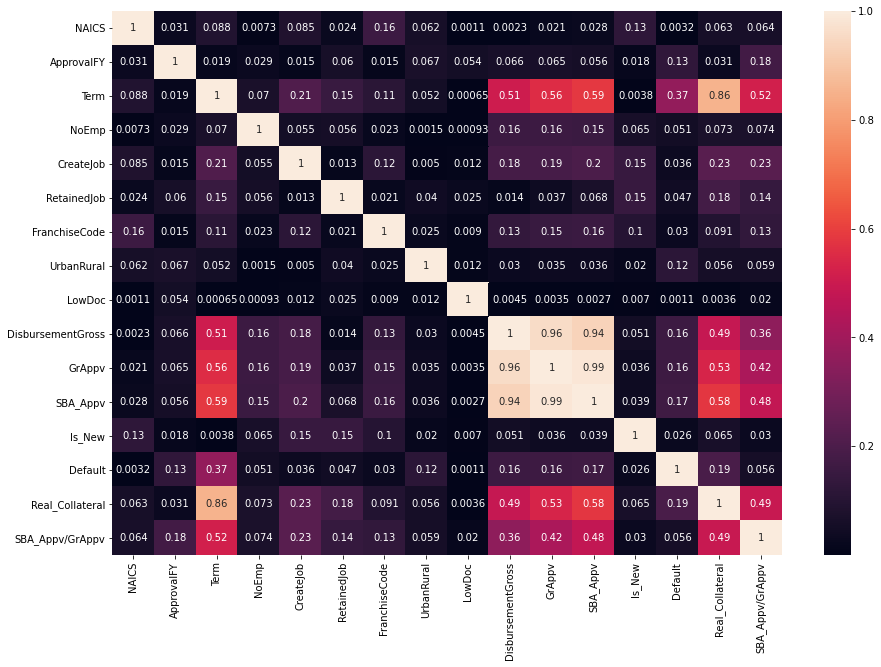

In [47]:
plt.subplots(figsize=(15, 10))
sns.heatmap(abs(df_9.corr()), annot=True)
plt.show()

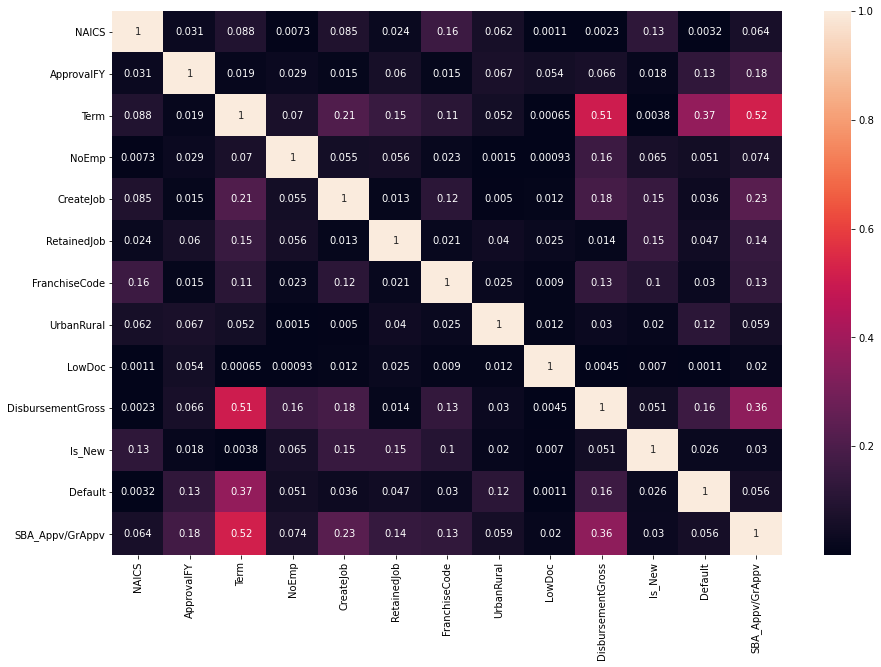

In [48]:
# Since we'll be fitting a logistic regression model later on, I'll be setting aside a dataset,
# that is friendlier to the assumptions of the logistic regression.
logit_data = df_9.drop(columns=['State','Real_Collateral', 'SBA_Appv', 'GrAppv'])
plt.subplots(figsize=(15, 10))
sns.heatmap(abs(logit_data.corr()), annot=True)
plt.show()

In [49]:
logit_data = pd.get_dummies(logit_data, drop_first=True)

In [50]:
df_10 = pd.get_dummies(df_9, drop_first=True).drop(columns=['NAICS'])
df_10

,ApprovalFY,Term,NoEmp,CreateJob,RetainedJob,FranchiseCode,UrbanRural,LowDoc,DisbursementGross,GrAppv,...,Industry_Mgmt_comp,Industry_Min/Quar/Oil_Gas_ext,Industry_Other_no_pub,Industry_Prof/Science/Tech,Industry_Public_Admin,Industry_RE/Rental/Lease,Industry_Retail_trade,Industry_Trans/Ware,Industry_Utilities,Industry_Wholesale_trade
402,2006,6,6,0,1,0,1,0,40254.0,25000.0,...,0,0,0,0,0,0,0,0,0,0
420,2006,20,1,1,0,0,1,0,1197000.0,1197000.0,...,0,0,1,0,0,0,0,0,0,0
463,2006,20,6,1,1,0,1,0,263000.0,263000.0,...,0,0,1,0,0,0,0,0,0,0
470,2006,20,3,1,1,0,2,0,264000.0,264000.0,...,0,0,0,0,0,0,1,0,0,0
620,2006,20,15,1,1,1,1,0,1352000.0,1352000.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893442,2006,20,2,1,0,0,1,0,229000.0,229000.0,...,0,0,0,0,0,0,1,0,0,0
894473,2006,5,2,1,1,0,1,0,40000.0,40000.0,...,0,0,0,0,0,0,0,0,0,0
894536,2006,20,10,1,0,0,2,0,150000.0,150000.0,...,0,0,0,0,0,0,0,0,0,0
894766,2006,20,5,1,0,0,2,0,134000.0,134000.0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
# Whether the loan was active during the Great Recession 
#df_8['Disbursement_FY'] = pd.DatetimeIndex(df_8['DisbursementDate']).year
#df_8['GreatRecession'] = np.where(((2007 <= df_8['Disbursement_FY']) & (df_8['Disbursement_FY'] <= 2009)) | 
#                                     ((df_8['Disbursement_FY'] < 2007) & (df_8['Disbursement_FY'] + (df_8['Term'] >= 2007)), 1, 0))

# Model Evaluation

We'll need to focus on select metrics by which to evaluate the efficacy of our models. ROC_AUC score initially comes to mind because, the closer the score is 1, the better our model is doing classifying True Positives and False Positives. 

However, we have to consider the stakes at hand. A False Negative presents the largest opportunity cost for both the lender and the Small Business Administration. Our model not being able to successfully predict whether a loan will default has greater consequences, than if our model predicts a loan for default when it never would have(False Positive). 

Therefore, the F1 score would take into consideration false negatives, because it is a harmonious mean of precision and recall. So that will be our metric of focus.

We will be using a RepeatedStratifiedKfold, in order to address the class imbalance. Stratification allows us to conduct random sampling in order to maintain the class-label proportion across the different folds. 

We'll also generate a classification report for each model.

In [52]:
def results(model):
    """Returns metric scores, a classification report, and a confusion matrix."""
    time_start = time.time()
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    print('| Train Accuracy:', model.score(X_train, y_train),
          '\n| Test Accuracy:', model.score(X_test, y_test),
          '\n| ROC_AUC_Score:', roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
          '\n| Execution time: {}'.format(time.time() - time_start))
    print(classification_report(y_test, y_test_pred))
    plot_confusion_matrix(model, X_test, y_test, values_format='.5g', cmap='Blues')
    plt.show()

We can establish a baseline of performance for the models we will be evaluating, by generating an accuracy score
for a Dummy Classifier (the score has quite a bit to do with the class imbalance and is therfore not the best metric).
Regardless, our models should generate AT LEAST the same accuracy as our DummyClassifier.

Mean F1 score: 0.000
| Train Accuracy: 0.6632642452767775 
| Test Accuracy: 0.6635288780515467 
| ROC_AUC_Score: 0.5 
| Execution time: 0.04788780212402344
              precision    recall  f1-score   support

           0       0.66      1.00      0.80     23402
           1       0.00      0.00      0.00     11867

    accuracy                           0.66     35269
   macro avg       0.33      0.50      0.40     35269
weighted avg       0.44      0.66      0.53     35269



C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


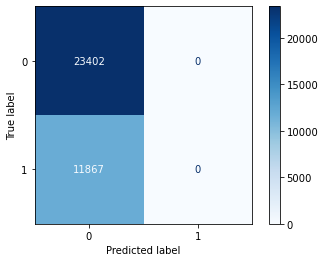

In [53]:
from sklearn.dummy import DummyClassifier

y = df_10.Default
X = df_10.drop(columns=['Default'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

dummy = DummyClassifier(strategy = 'most_frequent')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(dummy, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)

dummy.fit(X_train, y_train)
print('Mean F1 score: %.3f' %(scores.mean()))
results(dummy)

## Logisitic Regression:

Logistic Regression operates from various assumptions:

1) A (Balanced) Binary Output Variable

2) Very little noise (minimal outliers and misclassification in the training data)

3) A Gaussian distributions-it assumes a linear relationship between the input and output variable, meaning a log, root or box-cox transformation may be needed

4) Minimal Multicollinearity, as high multicollinearity can cause overfitting of the model to training data

Logistic Regression Models, while effective for binary classifications, are more ineffectual with imbalanced classifications.

Furthermore, we can see the difference in the Logistic Regression fit to a dataset, friendly to it's underlying assumptions vs one that is not.

Mean F1 score: 0.116
| Train Accuracy: 0.6631602824009754 
| Test Accuracy: 0.6633587569820523 
| ROC_AUC_Score: 0.5302003625099705 
| Execution time: 0.5376119613647461
              precision    recall  f1-score   support

           0       0.66      1.00      0.80     23402
           1       0.12      0.00      0.00     11867

    accuracy                           0.66     35269
   macro avg       0.39      0.50      0.40     35269
weighted avg       0.48      0.66      0.53     35269



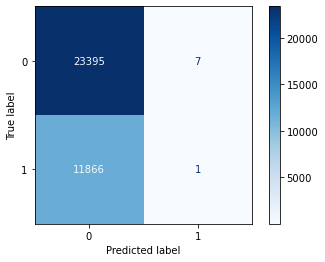

In [54]:
# Non-Friendly dataset for Logistic Regression
y = df_10.Default
X = df_10.drop(columns=['Default'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

logit = LogisticRegression()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(logit, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)

print('Mean F1 score: %.3f' %(scores.mean()))
logit.fit(X_train, y_train)
results(logit)

Mean F1 score: 0.382
| Train Accuracy: 0.7147542223104332 
| Test Accuracy: 0.7139981286682355 
| ROC_AUC_Score: 0.754213564640783 
| Execution time: 0.2493293285369873
              precision    recall  f1-score   support

           0       0.71      0.95      0.82     23402
           1       0.72      0.25      0.37     11867

    accuracy                           0.71     35269
   macro avg       0.72      0.60      0.59     35269
weighted avg       0.72      0.71      0.66     35269



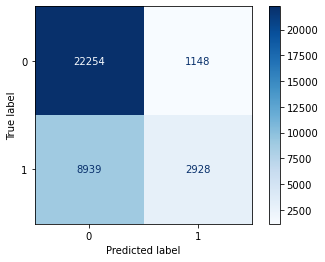

In [55]:
# Assumption-Friendly Logisitic Regression
y = logit_data.Default
X = logit_data.drop(columns=['Default'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

logit = LogisticRegression()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(logit, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)

logit.fit(X_train, y_train)
print('Mean F1 score: %.3f' %(scores.mean()))
results(logit)

### Cost-Sensitive Logistic Regression for Imbalanced Classes

In order to address the class imbalance, we can try to optimize the classification results for logistic regression by cycling through various weight balances for each class.

Best: 0.533826 using {'class_weight': {0: 1, 1: 2}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 2, 1: 1}}
0.381605 (0.035908) with: {'class_weight': {0: 1, 1: 1}}
0.533826 (0.011198) with: {'class_weight': {0: 1, 1: 2}}
0.509131 (0.000540) with: {'class_weight': {0: 1, 1: 10}}
0.503972 (0.000069) with: {'class_weight': {0: 1, 1: 100}}
| Train Accuracy: 0.5313095980946188 
| Test Accuracy: 0.5276783834982108 
| ROC_AUC_Score: 0.5933263614466946 
| Execution time: 0.39275622367858887
              precision    recall  f1-score   support

           0       0.80      0.31      0.45     23402
           1       0.38      0.85      0.53     11867

    accuracy                           0.49     35269
   macro avg       0.59      0.58      0.49     35269
weighted avg       0.66      0.49      0.47     35269



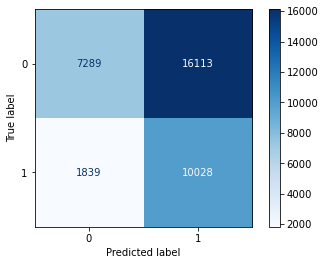

In [56]:
#Cost-Sensitive Logistic Regression for imbalanced classes
from sklearn.model_selection import RepeatedStratifiedKFold

y = logit_data.Default
X = logit_data.drop(columns=['Default'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

model = LogisticRegression(solver='lbfgs')

balance = [{0:100,1:1}, {0:10,1:1}, {0:2, 1:1}, {0:1,1:1}, {0:1,1:2}, {0:1,1:10}, {0:1,1:100}]
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
param_grid = dict(class_weight = balance)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, scoring='f1', cv=cv)

grid_result =grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
results(grid)

The GridSearch confirmed that a weight balance of 1:1 between the Default and Paid in Full classes, ultimately yields the lowest roc_auc_score.

## Random Forest Classifier

Note: We set the Random Forest Classifier with a hyperparameter of max_depth=10 because the default is 'None' meaning the model will extend into perpetuity, eventually overfitting the training data.

Mean F1 score: 0.757
| Train Accuracy: 0.8562665986182388 
| Test Accuracy: 0.8479401173835379 
| ROC_AUC_Score: 0.9195926241982965 
| Execution time: 1.393805980682373
              precision    recall  f1-score   support

           0       0.85      0.93      0.89     23263
           1       0.84      0.68      0.75     12006

    accuracy                           0.85     35269
   macro avg       0.85      0.81      0.82     35269
weighted avg       0.85      0.85      0.84     35269



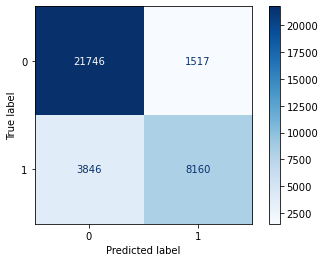

In [57]:
y = df_10.Default
X = df_10.drop(columns=['Default'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

rfc = RandomForestClassifier(n_estimators=10, max_depth=10)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(rfc, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)

print('Mean F1 score: %.3f' %(scores.mean()))
rfc.fit(X_train, y_train)
results(rfc)

## Easy Ensemble Classifier

Because are target variable classes are imbalanced, we can attempt an Easy Ensemble Classifier, which uses random under-sampling to create more balanced classes.

Mean F1 score: 0.777
| Train Accuracy: 0.8302758796676969 
| Test Accuracy: 0.8285179619495875 
| ROC_AUC_Score: 0.9087974699522603 
| Execution time: 82.01096630096436
              precision    recall  f1-score   support

           0       0.93      0.80      0.86     23378
           1       0.69      0.88      0.78     11891

    accuracy                           0.83     35269
   macro avg       0.81      0.84      0.82     35269
weighted avg       0.85      0.83      0.83     35269



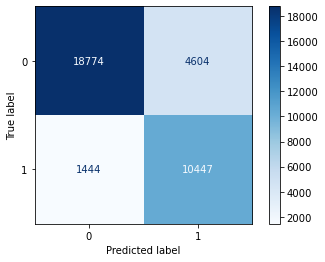

In [58]:
from sklearn.model_selection import cross_val_score
from imblearn.ensemble import EasyEnsembleClassifier

y = logit_data.Default
X = logit_data.drop(columns=['Default'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

eec = EasyEnsembleClassifier(n_estimators=10)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(eec, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)

print('Mean F1 score: %.3f' %(scores.mean()))
eec.fit(X_train, y_train)
results(eec)

## XGBoost Classifier

Mean F1 Score: 0.809
| Train Accuracy: 0.8754146701068928 
| Test Accuracy: 0.8704528055799711 
| ROC_AUC_Score: 0.9395836022424621 
| Execution time: 2.8794314861297607
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     23402
           1       0.82      0.79      0.80     11867

    accuracy                           0.87     35269
   macro avg       0.86      0.85      0.85     35269
weighted avg       0.87      0.87      0.87     35269



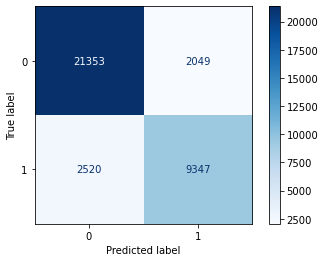

In [59]:
y = df_10.Default
X = df_10.drop(columns=['Default'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

xgb = XGBClassifier(n_estimators=10)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(xgb, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)

print('Mean F1 Score: %.3f' %(scores.mean()))
xgb.fit(X_train, y_train)
results(xgb)

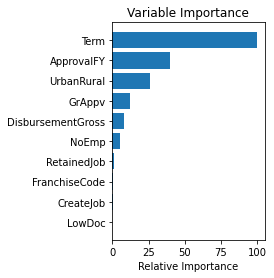

In [60]:
feature_importance = xgb.feature_importances_[:10]

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Mean F1 Score: 0.825
| Train Accuracy: 0.8933718941090855 
| Test Accuracy: 0.8819926847940117 
| ROC_AUC_Score: 0.9460107245671691 
| Execution time: 1.850254774093628
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     23402
           1       0.83      0.82      0.82     11867

    accuracy                           0.88     35269
   macro avg       0.87      0.87      0.87     35269
weighted avg       0.88      0.88      0.88     35269



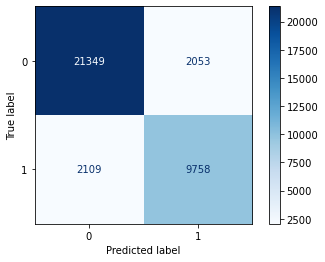

In [61]:
y = df_10.Default
X = df_10.drop(columns='Default')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

xgb = XGBClassifier(random_state=1)

pipe = Pipeline([
    ('feature_selection', SelectKBest()),
    ('model', xgb)
])

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipe, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)
pipe.fit(X_train, y_train)

print('Mean F1 Score: %.3f' %(scores.mean()))
results(pipe)

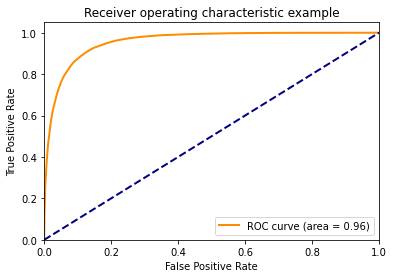

In [62]:
from sklearn.metrics import roc_curve, auc

train_pred_probs = pipe.predict_proba(X_train)
pred_probs = pd.Series(train_pred_probs[:, 1])
x, y, _ = roc_curve(y_train, pred_probs)
roc_auc = auc(x, y)

plt.figure()
lw = 2
plt.plot(x, y, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Conclusion

Ultimately, the analysis showed that we must reject the null hypothesis, as there are clear predictors for a loan entering a default status. Furthermore, term was shown to be the leading indicator for our best performing model (XGBClassifier). This could be for several reasons, including the correlation between term and Disbursement Gross (meaning larger monthly installments). 

With more time and computational ability, I would like to revisit all 1.2 million observations for both SBA loan programs.

Final Considertions: The data observed was solely for loan already approved, presumably by underwriting. We also don't have access to any type of credit metrics. The modeling will undoubtedly look different if loans prior to approval or denial are to be included in the dataset.

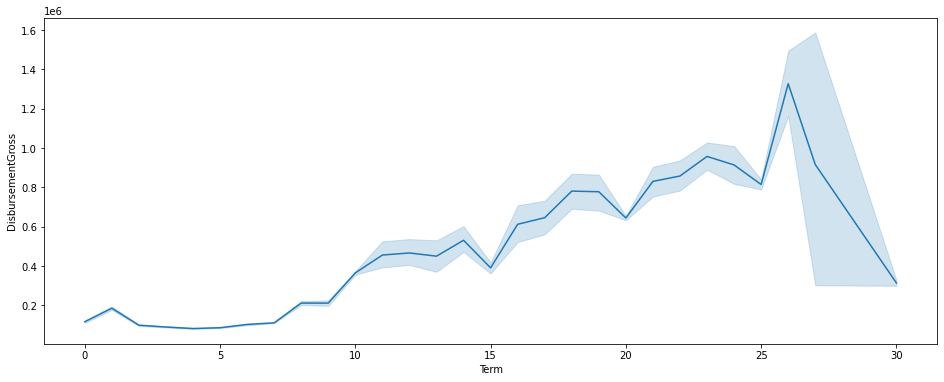

In [63]:
plt.figure(figsize=(16, 6))
ax= sns.lineplot(x='Term', y='DisbursementGross', data=df_9);